In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import RandomOverSampler
from collections import OrderedDict
import pickle
import warnings
warnings.simplefilter("ignore")

In [12]:
df = pd.read_csv('water_potability.csv')

In [13]:
df.shape

(3276, 10)

In [14]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


# Custom Summary
## Descriptive statistics of numeric features

In [15]:
def descriptive_statistics(data) :
    
    result = []
    
    for col in data.columns :
        
        if data[col].dtype != 'O':   
            
 # initialise the dictionary
            stats = OrderedDict({
                "Feature_Name" : col ,
                "Count" : data[col].count() , 
                "Minimum" : data[col].min(),
                "First quartile" :data[col].quantile(0.25),
                "Mean" : data[col].mean(),
                "Median" : data[col].median(),
                "Third quartile":data[col].quantile(0.75),
                "Maximum" : data[col].max(),
                "Variance" : data[col].var(),
                "standard deviation": data[col].std(),
                "Kurtosis" : data[col].kurt(),
                "Skewness" : data[col].skew(),
                "IQR" : data[col].quantile(0.75) - data[col].quantile(0.25)
            })
            
            result.append(stats)
            
    
    result_df = pd.DataFrame(result)
    
    skewtype = []
    
    
    for i in result_df['Skewness'] :
        
        if i <= -1:
            skewtype.append("Highly Negatively Skewed")
            
        elif i<= -0.5:
            skewtype.append("Moderately Negatively Skewed")
            
        elif -0.5 < i < 0 :
            skewtype.append("Approx Normal Distribution(-ve)")
            
        elif 0 <= i < 0.5:
            skewtype.append("Approx Normal Distribution(+ve)")
            
        elif 0.5 <= i <1 :
             skewtype.append("Moderately positively skewed")
        
        elif i >= 1:
             skewtype.append("Highly positively skewed")
    
    
    result_df["Skew_Type"] = skewtype



    k_type = []
    
    
    for i in result_df['Kurtosis'] :
        
        if i <= -1  :
            k_type.append("Highly platykurtic curve")
            
        elif -1 < i <= 0.5 :
            k_type.append("Moderately platykurtic curve")
            
        elif -0.5 < i <= 0.5 :
            k_type.append("Mesokurtic curve")
            
        elif 0.5 < i <= 1 :
            k_type.append("Moderately leptokurtic curve")
            
        elif i > 1 :
            k_type.append("Highly leptokurtic curve")

    
    result_df["kurtosis_Type"] = k_type
    
    
   
    
    up_limit = stats["Third quartile"] + 1.5 * stats["IQR"]
    
    low_limit = stats["First quartile"] - 1.5 * stats["IQR"]
    
    if len([x for x in data[col] if x < low_limit or x > up_limit]) > 0 :
        outlier_comment = "Has outliers"
        outlier_percentage = len([x for x in data[col] if x < low_limit or x > up_limit]) / len(data)
    else:
        outlier_comment = "No outliers"
        outlier_percentage = 0
        
    result_df['Outlier_Comment'] = outlier_comment
    
    result_df['Outlier_Percentage'] = outlier_percentage

    
    return result_df
    


In [16]:
descrp_stats = descriptive_statistics(df)

In [17]:
descrp_stats

,Feature_Name,Count,Minimum,First quartile,Mean,Median,Third quartile,Maximum,Variance,standard deviation,Kurtosis,Skewness,IQR,Skew_Type,kurtosis_Type,Outlier_Comment,Outlier_Percentage
0,ph,2785,0.000000,6.093092,7.080795,7.036752,8.062066,14.000000,2.541855e+00,1.594320,0.720316,0.025630,1.968974,Approx Normal Distribution(+ve),Moderately leptokurtic curve,No outliers,0
1,Hardness,3276,47.432000,176.850538,196.369496,196.967627,216.667456,323.124000,1.081079e+03,32.879761,0.615772,-0.039342,39.816918,Approx Normal Distribution(-ve),Moderately leptokurtic curve,No outliers,0
2,Solids,3276,320.942611,15666.690300,22014.092526,20927.833605,27332.762125,61227.196010,7.688783e+07,8768.570828,0.442826,0.621634,11666.071825,Moderately positively skewed,Moderately platykurtic curve,No outliers,0
3,Chloramines,3276,0.352000,6.127421,7.122277,7.130299,8.114887,13.127000,2.506158e+00,1.583085,0.589901,-0.012098,1.987466,Approx Normal Distribution(-ve),Moderately leptokurtic curve,No outliers,0
4,Sulfate,2495,129.000000,307.699498,333.775777,333.073546,359.950170,481.030642,1.715355e+03,41.416840,0.648263,-0.035947,52.250673,Approx Normal Distribution(-ve),Moderately leptokurtic curve,No outliers,0
5,Conductivity,3276,181.483754,365.734414,426.205111,421.884968,481.792305,753.342620,6.532529e+03,80.824064,-0.277093,0.264490,116.057890,Approx Normal Distribution(+ve),Moderately platykurtic curve,No outliers,0
6,Organic_carbon,3276,2.200000,12.065801,14.284970,14.218338,16.557652,28.300000,1.094394e+01,3.308162,0.044409,0.025533,4.491850,Approx Normal Distribution(+ve),Moderately platykurtic curve,No outliers,0
7,Trihalomethanes,3114,0.738000,55.844536,66.396293,66.622485,77.337473,124.000000,2.616309e+02,16.175008,0.238597,-0.083031,21.492937,Approx Normal Distribution(-ve),Moderately platykurtic curve,No outliers,0
8,Turbidity,3276,1.450000,3.439711,3.966786,3.955028,4.500320,6.739000,6.089967e-01,0.780382,-0.062801,-0.007817,1.060609,Approx Normal Distribution(-ve),Moderately platykurtic curve,No outliers,0
9,Potability,3276,0.000000,0.000000,0.390110,0.000000,1.000000,1.000000,2.379968e-01,0.487849,-1.797892,0.450784,1.000000,Approx Normal Distribution(+ve),Highly platykurtic curve,No outliers,0


In [18]:
# No outliers present in any of the features

## Feature Engineering

In [16]:
# Percentage of missing values in each feature

((df.isnull().sum()/len(df))*100).sort_values(ascending=False)

Sulfate            23.840049
ph                 14.987790
Trihalomethanes     4.945055
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Conductivity        0.000000
Organic_carbon      0.000000
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [17]:
# Treating missing values
#1) Trihalomethanes
#2) pH
#3) Sulfate

<AxesSubplot:xlabel='Sulfate', ylabel='Density'>

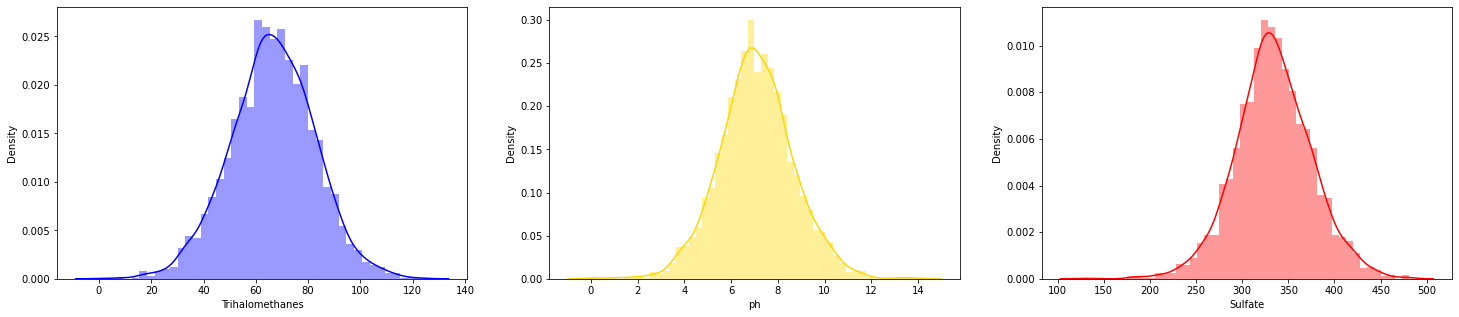

In [18]:
# Distribution before imputing missing values

plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.distplot(df['Trihalomethanes'], color = 'Blue', label='Trihalomethanes')
plt.subplot(1,3,2)
sns.distplot(df['ph'], color = 'gold', label='pH')
plt.subplot(1,3,3)
sns.distplot(df['Sulfate'], color = 'red', label='Sulfate')

In [19]:
# Making a list of all column names

columns=[]
for i in df.columns:
    columns.append(i)

In [20]:
# Using KNN Imputer for imputing the missing values

imputer = KNNImputer(n_neighbors=3,  weights='uniform')
imputer.fit(df)
df=imputer.transform(df)

In [21]:
df = pd.DataFrame(df, columns=columns)

In [22]:
# Percentage of missing values in each feature after imputation

(df.isnull().sum()/len(df))*100

ph                 0.0
Hardness           0.0
Solids             0.0
Chloramines        0.0
Sulfate            0.0
Conductivity       0.0
Organic_carbon     0.0
Trihalomethanes    0.0
Turbidity          0.0
Potability         0.0
dtype: float64

<AxesSubplot:xlabel='Sulfate', ylabel='Density'>

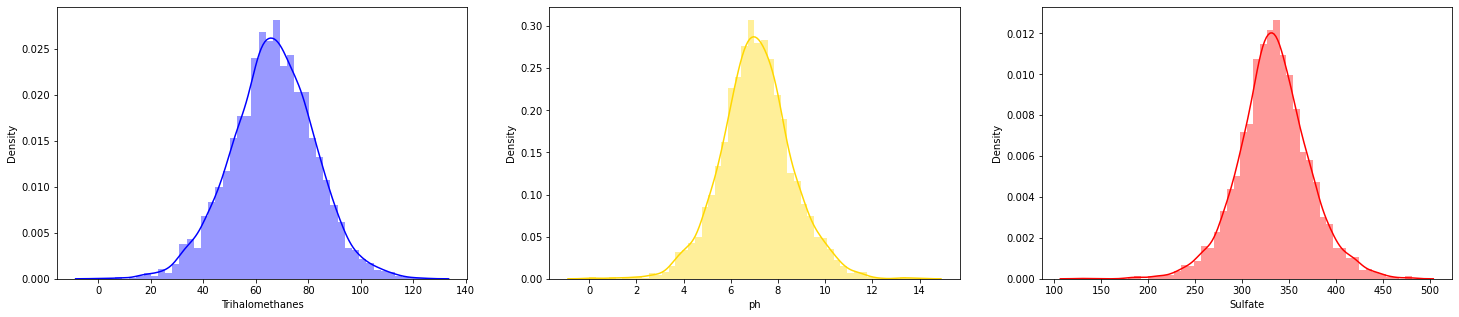

In [23]:
# Distribution after imputing missing values

plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.distplot(df['Trihalomethanes'], color = 'Blue', label='Trihalomethanes')
plt.subplot(1,3,2)
sns.distplot(df['ph'], color = 'gold', label='pH')
plt.subplot(1,3,3)
sns.distplot(df['Sulfate'], color = 'red', label='Sulfate')

When we compare the distribution of each feature before and after imputation, the distribution remains relatively the same.

### Oversampling

In [24]:
# Splitting the data into X and y

X = df.drop('Potability', axis=1)
y = df['Potability']

<AxesSubplot:xlabel='Potability', ylabel='count'>

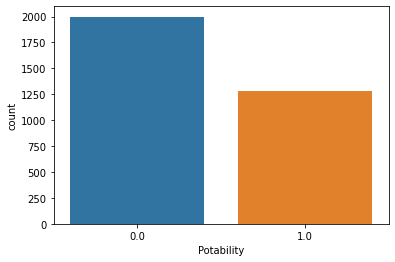

In [25]:
sns.countplot(y)

As we can see the target variable is imbalanced. Let us fix that by performing Oversampling.

In [26]:
ros = RandomOverSampler()
X, y = ros.fit_resample(X, y)

<AxesSubplot:xlabel='Potability', ylabel='count'>

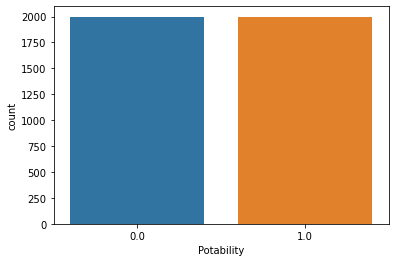

In [27]:
sns.countplot(y)

The target feature is now balanced

In [28]:
#Feature Selection

bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X,y)

In [29]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [30]:
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

In [31]:
featureScores

,Specs,Score
0,ph,0.178167
1,Hardness,9.077850
2,Solids,12885.925017
3,Chloramines,1.884923
4,Sulfate,0.736389
5,Conductivity,7.974265
6,Organic_carbon,3.925096
7,Trihalomethanes,0.154774
8,Turbidity,0.030137


In [32]:
print(featureScores.nlargest(9,'Score'))  #print 10 best features

             Specs         Score
2           Solids  12885.925017
1         Hardness      9.077850
5     Conductivity      7.974265
6   Organic_carbon      3.925096
3      Chloramines      1.884923
4          Sulfate      0.736389
0               ph      0.178167
7  Trihalomethanes      0.154774
8        Turbidity      0.030137


In [33]:
# Training the model with the top 6 most important features

X.drop(['Turbidity', 'Conductivity', 'Chloramines'], axis=1, inplace=True)

In [34]:
# Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [35]:
X_train

,ph,Hardness,Solids,Sulfate,Organic_carbon,Trihalomethanes
1340,6.441766,174.781849,11306.26151,327.289604,17.109829,89.122026
2487,9.349470,252.148499,13137.49076,320.323984,13.109898,58.801291
810,0.989912,133.216942,16922.85390,444.375731,10.430076,43.578466
1132,7.058183,187.947191,26608.92915,405.403423,18.428387,41.290330
1614,6.528491,184.429159,10835.20116,378.775720,13.621325,100.821792
...,...,...,...,...,...,...
2809,8.257597,208.404166,20109.02627,235.770982,14.410778,74.984937
6,10.223862,248.071735,28749.71654,393.663395,13.789695,84.603556
2550,7.957114,199.107505,20425.76649,380.078173,14.537850,62.246358
1688,8.031055,222.628424,18134.83502,314.471566,12.065963,78.549712


In [36]:
# Logistic Regression

lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred=lg.predict(X_test)
accuracy_score(y_test, y_pred)

0.4662218515429525

In [37]:
# Decision Tree Classifier

dt = DecisionTreeClassifier(criterion='gini', max_depth=21)
dt.fit(X_train, y_train)
y_pred=dt.predict(X_test)
accuracy_score(y_test, y_pred)

0.6688907422852377

In [38]:
# Decision Tree Cross validation score 

scores = cross_val_score(dt, X, y, cv=10)
print('The mean accuracy is ', np.mean(scores))

The mean accuracy is  0.7072813283208019


In [39]:
# Hyperparameter tuning

param = {"criterion": ["gini", "entropy"],
         "max_depth": range(1,40)}

grid_cv = GridSearchCV(dt, param, cv = 5)

grid_cv.fit(X_train, y_train)
  
grid_cv.best_params_

{'criterion': 'entropy', 'max_depth': 37}

In [40]:
# KNN 

knn = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_neighbors=4, weights='distance')
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.6488740617180984

In [41]:
# KNN Cross validation score

scores = cross_val_score(knn, X, y, cv=10)
print('The mean accuracy is ', np.mean(scores))

The mean accuracy is  0.6847606516290725


# Hyperparameter tuning

param_dist = {"n_neighbors": range(1,21),
              "weights": ['uniform', 'distance'],
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
              "metric": ['minkowski', "euclidean"]}

grid_cv = GridSearchCV(knn, param_dist, cv = 5)

grid_cv.fit(X_train, y_train)
  
grid_cv.best_params_

In [42]:
# Random Forest Classifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7264386989157632

In [43]:
# Random Forest Cross validation score

scores = cross_val_score(rf, X, y, cv=10)
print('The mean accuracy is ', np.mean(scores))

The mean accuracy is  0.7668395989974938


In [44]:
# Creating pickle file

filename = 'random_forest.pkl'
pickle.dump(rf, open(filename, 'wb'))

In [34]:
# Random Forest Hyperparameter tuning
#params = {"n_estimators": range(10,310,10), "criterion": ['gini', 'entropy'], "max_depth": range(3,50)}

#grid_cv = GridSearchCV(rf, params, cv = 10)

#grid_cv.fit(X_train, y_train)
  
#grid_cv.best_params_

In [38]:
# XGBoost

xgb = XGBClassifier(learning_rate=0.7)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

[18:52:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
accuracy_score(y_test, y_pred)

0.6972477064220184

In [40]:
# XGBoost Cross validation score

scores = cross_val_score(xgb, X, y, cv=10)
print('The mean accuracy is ', np.mean(scores))

[18:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [37]:
# Hyperparameter Tuning

params = {'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}

grid_cv = GridSearchCV(xgb, params, cv = 10)

grid_cv.fit(X_train, y_train)
  
grid_cv.best_params_

[18:51:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:51:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:51:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[18:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'learning_rate': 0.7}

In [46]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,6.655223,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0.0
1,3.716080,129.422921,18630.057858,6.635246,351.285226,592.885359,15.180013,56.329076,4.500656,0.0
2,8.099124,224.236259,19909.541732,9.275884,347.323743,418.606213,16.868637,66.420093,3.055934,0.0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0.0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0.0
